In [2]:
## Standard libraries
from PIL import Image
import numpy as np
import cv2

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch
from model import VisionTransformer

## Torchvision
import torchvision
from torchvision import transforms

## EuroSAT and ViT
from model import img_to_patch
from dataset import EuroSAT, random_split
from predict import get_transform_EuroSAT

/Users/TemporaryAdmin/Documents/MLSI/ViT/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.1 Prepare transforms for images

In [3]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


2.2 Turn images into DataLoader's

Let's now create our DataLoader's.

The ViT paper states the use of a batch size of 4096 which is 128x the size of the batch size we've been using (32).

However, we're going to stick with a batch size of 32.

Because some hardware (including the free tier of Google Colab) may not be able to handle a batch size of 4096.

Having a batch size of 4096 means that 4096 images need to fit into the GPU memory at a time.

Note: We're using the pin_memory=True parameter in the create_dataloaders() function to speed up computation. pin_memory=True avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that have been seen before.

In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

In [ ]:
2.3 Visualize a single image

In [ ]:
4.1 Calculating patch embedding input and output shapes by hand

In [ ]:
How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as H, W etc) above.

We'll use a patch size (P) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [4]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [ ]:

We've got the number of patches, how about we create the image output size as well?

Better yet, let's replicate the input and output shapes of the patch embedding layer.

Recall:

Input: The image starts as 2D with size H × W × C .
Output: The image gets converted to a sequence of flattened 2D patches with size N × (P2 ⋅ C) .

In [5]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [ ]:
4.3 Creating image patches with torch.nn.Conv2d()

In [20]:
img_url = "data/2750/River/River_5.jpg"

image = Image.open(img_url)
image

save = torch.load('../weights/best.pt', map_location='cpu')
normalization = save['normalization']
model = VisionTransformer(embed_dim=256, hidden_dim=512, num_heads=8, num_layers=6, patch_size=4, num_channels=3,
                          num_patches=64, num_classes=10, dropout=0.2)
model.load_state_dict(save['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()

tr = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
# tr = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(**normalization)])
# tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize(**normalization)])

x = tr(image)
x.size()

torch.Size([3, 224, 224])

In [ ]:
By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

Remember our ideal input and output shapes for the patch embedding layer?

Input: The image starts as 2D with size H×W×C.
Output: The image gets converted to a 1D sequence of flattened 2D patches with size N×(P2⋅C).

Or for an image size of 224 and patch size of 16:

Input (2D image): (224, 224, 3) -> (height, width, color channels)
Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:

torch.nn.Conv2d() for turning our image into patches of CNN feature maps.
torch.nn.Flatten() for flattening the spatial dimensions of the feature map.
Let's start with the torch.nn.Conv2d() layer.

We can replicate the creation of patches by setting the kernel_size and stride equal to patch_size.

This means each convolutional kernel will be of size (patch_size x patch_size) or if patch_size=16, (16 x 16) (the equivalent of one whole patch).

And each step or stride of the convolutional kernel will be patch_size pixels long or 16 pixels long (equivalent of stepping to the next patch).

We'll set in_channels=3 for the number of color channels in our image and we'll set out_channels=768, the same as the D value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [21]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

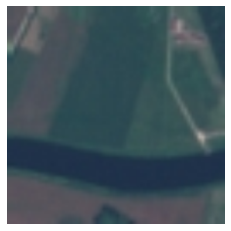

In [26]:
# View single image
plt.imshow(x.permute(1, 2, 0)) # adjust for matplotlib
# plt.title(class_names[label])
plt.axis(False);

In [23]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(x.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [ ]:
Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or D) feature/activation maps.

So its output shape can be read as:

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [28, 598, 470, 234, 748, 334, 544, 88, 561, 79]


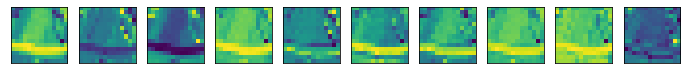

In [33]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=10) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [34]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


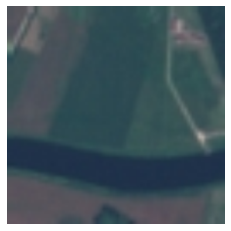

In [35]:
# 1. View single image
plt.imshow(x.permute(1, 2, 0)) # adjust for matplotlib
# plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {x.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(x.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [36]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


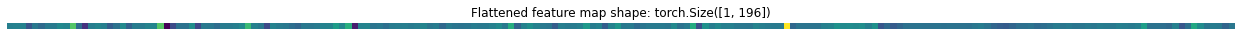

In [37]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
4.6 Creating the class token embedding¶

In [48]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [52]:
# set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {x.unsqueeze(0).shape}")
patch_embedded_image = patchify(x.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [58]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]   [1, 196, 768]      --                 True
├─Conv2d (patcher)                       [1, 3, 224, 224]   [1, 768, 14, 14]   590,592            True
├─Flatten (flatten)                      [1, 768, 14, 14]   [1, 768, 196]      --                 --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [61]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 32, 32) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
# vit = ViT(num_classes=len(class_names))
_vit = VisionTransformer(embed_dim=256, hidden_dim=512, num_heads=8, num_layers=6, patch_size=4, num_channels=3, num_patches=64, num_classes=10, dropout=0.2)

# Pass the random image tensor to our ViT instance
_vit(random_image_tensor)

(tensor([[-0.3502, -0.0776,  1.0846, -0.0248,  0.6039,  0.0212, -0.2145, -0.7443,
          -0.2925, -0.1463]], grad_fn=<AddmmBackward0>),
 [tensor([[[[0.0195, 0.0098, 0.0047,  ..., 0.0128, 0.0243, 0.0064],
            [0.0097, 0.0147, 0.0123,  ..., 0.0137, 0.0138, 0.0034],
            [0.0091, 0.0179, 0.0103,  ..., 0.0252, 0.0142, 0.0104],
            ...,
            [0.0374, 0.0087, 0.0528,  ..., 0.0204, 0.0294, 0.0089],
            [0.0261, 0.0157, 0.0119,  ..., 0.0147, 0.0418, 0.0055],
            [0.0145, 0.0175, 0.0052,  ..., 0.0233, 0.0048, 0.0243]],
  
           [[0.0079, 0.0143, 0.0087,  ..., 0.0061, 0.0205, 0.0175],
            [0.0180, 0.0150, 0.0227,  ..., 0.0119, 0.0132, 0.0094],
            [0.0174, 0.0134, 0.0044,  ..., 0.0153, 0.0139, 0.0205],
            ...,
            [0.0262, 0.0190, 0.0098,  ..., 0.0375, 0.0094, 0.0082],
            [0.0118, 0.0167, 0.0087,  ..., 0.0145, 0.0062, 0.0152],
            [0.0135, 0.0088, 0.0090,  ..., 0.0241, 0.0169, 0.0091]],
  
   

In [64]:
from torchinfo import summary

# Create an instance of TransformerEncoderBlock
_vit = VisionTransformer(embed_dim=256, hidden_dim=512, num_heads=8, num_layers=6, patch_size=4, num_channels=3, num_patches=64, num_classes=10, dropout=0.2)

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=_vit,
        input_size=(1, 3, 32, 32) , # (batch_size, num_patches, embedding_dimension)
        # input_size=(3, 32, 32), # (batch_size, num_patches, embedding_dimension)
        # input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"])
# summary(PatchEmbedding(),
#         input_size=random_input_image, # try swapping this for "random_input_image_error"
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=18,
#         row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                             [1, 3, 32, 32] [1, 10]    16,896     True
├─Linear (input_layer)                                            [1, 64, 48] [1, 64, 256] 12,544     True
├─Dropout (dropout)                                               [1, 65, 256] [1, 65, 256] --         --
├─Sequential (transformer)                                        --         --         --         --
│    └─AttentionBlock (0)                                         [65, 1, 256] [65, 1, 256] --         True
│    │    └─LayerNorm (layer_norm_1)                              [65, 1, 256] [65, 1, 256] 512        True
│    │    └─MultiheadAttention (attn)                             [65, 1, 256] [65, 1, 256] 263,168    True
│    │    └─LayerNorm (layer_norm_2)                              [65, 1, 256] [65, 1, 256] 512        True
│    │    └─Sequential (linear)  

In [6]:
# Get the test set
tr = get_transform_EuroSAT()
dataset = EuroSAT(transform=tr)
trainval, _ = random_split(dataset, 0.9, random_state=42)
_, test_ds = random_split(trainval, 0.9, random_state=7)

# Visualize some examples
NUM_IMAGES = 4
EuroSAT_images = torch.stack([test_ds[idx][0] for idx in range(NUM_IMAGES)], dim=0)
EuroSAT_images.shape

torch.Size([4, 3, 32, 32])

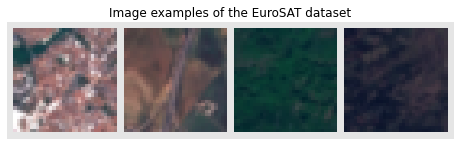

In [7]:
img_grid = torchvision.utils.make_grid(EuroSAT_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the EuroSAT dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

As a preprocessing step, we split an image of, for example,  pixels into 64 patches. Each of those patches is considered to be a “word”/”token” and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task.

For our images of size, we choose a patch size of 4. Hence, we obtain sequences of 64 patches of size. We visualize them below:

In [9]:
img_patches = img_to_patch(EuroSAT_images, patch_size=4)
img_patches.shape

torch.Size([4, 64, 48])

In [10]:
img_patches = img_to_patch(EuroSAT_images, patch_size=4, flatten_channels=False)
img_patches.shape

torch.Size([4, 64, 3, 4, 4])

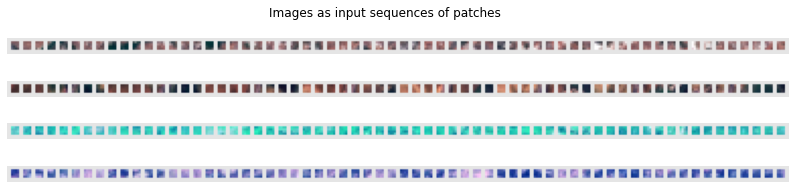

In [11]:
fig, ax = plt.subplots(EuroSAT_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(EuroSAT_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [24]:
img_patches = img_to_patch(EuroSAT_images, patch_size=4)
img_patches.shape

torch.Size([4, 64, 48])

In [25]:
from torch import nn

In [27]:
im = img_patches #[1]
im.shape

torch.Size([4, 64, 48])

In [30]:
embed_dim = 256
patch_size = 4
num_channels = 3  # Bands
ln = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
ln(im).shape

torch.Size([4, 64, 256])

In [40]:
cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
B = 64
_cls_token = cls_token.repeat(B, 1, 1)
x = torch.cat([_cls_token, ln], dim=1)

TypeError: expected Tensor as element 1 in argument 0, but got Linear

In [38]:
cls_token.shape

torch.Size([1, 1, 256])

In [105]:
save = torch.load('weights/best.pt', map_location='cpu')
normalization = save['normalization']
model = VisionTransformer(embed_dim=256, hidden_dim=512, num_heads=8, num_layers=6, patch_size=4, num_channels=3,
                          num_patches=64, num_classes=10, dropout=0.2)
model.load_state_dict(save['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()

tr = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(**normalization)])
# tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize(**normalization)])

x = tr(im)
x.size()

torch.Size([3, 32, 32])

In [106]:
x

tensor([[[-0.1360, -0.0370,  0.0816,  ..., -0.9668, -0.9272, -0.9470],
         [-0.0964, -0.0173,  0.1212,  ..., -0.9470, -0.9668, -0.9866],
         [-0.0568,  0.0223,  0.2795,  ..., -0.9074, -0.8877, -0.9470],
         ...,
         [-0.0766, -0.0568, -0.0568,  ..., -0.3338, -0.2349, -0.2942],
         [ 0.1014,  0.0816,  0.0421,  ..., -0.3140, -0.2349, -0.2942],
         [ 0.2003,  0.2003,  0.1410,  ..., -0.2546, -0.2151, -0.2942]],

        [[-0.4156, -0.3563, -0.2081,  ..., -0.9492, -0.8603, -0.8603],
         [-0.3860, -0.3267, -0.0598,  ..., -0.9789, -0.9196, -0.9196],
         [-0.3563, -0.2674,  0.2366,  ..., -0.9196, -0.8603, -0.9196],
         ...,
         [-0.3563, -0.3860, -0.3860,  ..., -0.3267, -0.0895, -0.0895],
         [-0.3267, -0.3563, -0.3563,  ..., -0.2674, -0.0598, -0.0895],
         [-0.2970, -0.2970, -0.3563,  ..., -0.1784, -0.0598, -0.1191]],

        [[-0.4973, -0.4619, -0.3203,  ..., -0.9572, -0.8865, -0.8865],
         [-0.4619, -0.3911, -0.1434,  ..., -0

In [107]:
x.unsqueeze(0)

tensor([[[[-0.1360, -0.0370,  0.0816,  ..., -0.9668, -0.9272, -0.9470],
          [-0.0964, -0.0173,  0.1212,  ..., -0.9470, -0.9668, -0.9866],
          [-0.0568,  0.0223,  0.2795,  ..., -0.9074, -0.8877, -0.9470],
          ...,
          [-0.0766, -0.0568, -0.0568,  ..., -0.3338, -0.2349, -0.2942],
          [ 0.1014,  0.0816,  0.0421,  ..., -0.3140, -0.2349, -0.2942],
          [ 0.2003,  0.2003,  0.1410,  ..., -0.2546, -0.2151, -0.2942]],

         [[-0.4156, -0.3563, -0.2081,  ..., -0.9492, -0.8603, -0.8603],
          [-0.3860, -0.3267, -0.0598,  ..., -0.9789, -0.9196, -0.9196],
          [-0.3563, -0.2674,  0.2366,  ..., -0.9196, -0.8603, -0.9196],
          ...,
          [-0.3563, -0.3860, -0.3860,  ..., -0.3267, -0.0895, -0.0895],
          [-0.3267, -0.3563, -0.3563,  ..., -0.2674, -0.0598, -0.0895],
          [-0.2970, -0.2970, -0.3563,  ..., -0.1784, -0.0598, -0.1191]],

         [[-0.4973, -0.4619, -0.3203,  ..., -0.9572, -0.8865, -0.8865],
          [-0.4619, -0.3911, -

In [108]:
x.unsqueeze(0).size()

torch.Size([1, 3, 32, 32])

In [109]:
logits, att_mat = model(x.unsqueeze(0))
att_mat

[tensor([[[[1.2520e-04, 5.0677e-04, 1.5039e-04,  ..., 3.3863e-03,
            6.1875e-05, 1.0630e-04],
           [2.2739e-02, 1.4528e-02, 8.3667e-03,  ..., 1.8927e-02,
            7.2186e-03, 2.8291e-02],
           [1.8375e-02, 1.3107e-02, 9.1780e-03,  ..., 8.2989e-03,
            8.0956e-03, 1.3557e-02],
           ...,
           [1.6457e-02, 1.2377e-02, 1.1267e-02,  ..., 1.2892e-02,
            1.1074e-02, 3.4172e-02],
           [2.3643e-02, 1.4214e-02, 6.9254e-03,  ..., 7.4096e-03,
            1.3637e-02, 6.7225e-03],
           [1.3651e-02, 1.1546e-02, 1.6293e-02,  ..., 1.9538e-02,
            2.8561e-02, 3.2638e-02]],
 
          [[1.9968e-08, 2.3448e-08, 1.1496e-08,  ..., 1.9384e-07,
            7.4709e-08, 4.1416e-06],
           [1.1514e-02, 1.6554e-02, 5.7295e-03,  ..., 8.1725e-03,
            9.0545e-03, 2.0835e-02],
           [9.4730e-03, 3.4187e-03, 1.9310e-02,  ..., 9.9912e-03,
            3.1933e-03, 1.6182e-02],
           ...,
           [2.2677e-02, 1.1147e-02, 1.

In [110]:
len(att_mat)

6

In [111]:
att_mat[5].size()

torch.Size([1, 8, 65, 65])

In [112]:
torch.stack(att_mat).size()

torch.Size([6, 1, 8, 65, 65])

In [113]:
torch.stack(att_mat).squeeze(1).size()

torch.Size([6, 8, 65, 65])

In [114]:
att_mat2 = torch.stack(att_mat).squeeze(1)
att_mat2

tensor([[[[1.2520e-04, 5.0677e-04, 1.5039e-04,  ..., 3.3863e-03,
           6.1875e-05, 1.0630e-04],
          [2.2739e-02, 1.4528e-02, 8.3667e-03,  ..., 1.8927e-02,
           7.2186e-03, 2.8291e-02],
          [1.8375e-02, 1.3107e-02, 9.1780e-03,  ..., 8.2989e-03,
           8.0956e-03, 1.3557e-02],
          ...,
          [1.6457e-02, 1.2377e-02, 1.1267e-02,  ..., 1.2892e-02,
           1.1074e-02, 3.4172e-02],
          [2.3643e-02, 1.4214e-02, 6.9254e-03,  ..., 7.4096e-03,
           1.3637e-02, 6.7225e-03],
          [1.3651e-02, 1.1546e-02, 1.6293e-02,  ..., 1.9538e-02,
           2.8561e-02, 3.2638e-02]],

         [[1.9968e-08, 2.3448e-08, 1.1496e-08,  ..., 1.9384e-07,
           7.4709e-08, 4.1416e-06],
          [1.1514e-02, 1.6554e-02, 5.7295e-03,  ..., 8.1725e-03,
           9.0545e-03, 2.0835e-02],
          [9.4730e-03, 3.4187e-03, 1.9310e-02,  ..., 9.9912e-03,
           3.1933e-03, 1.6182e-02],
          ...,
          [2.2677e-02, 1.1147e-02, 1.6173e-02,  ..., 9.5789

In [115]:
att_mat2.size()

torch.Size([6, 8, 65, 65])

In [116]:
att_mat3 = torch.mean(att_mat2, dim=1)
att_mat3

tensor([[[0.0023, 0.0218, 0.0097,  ..., 0.0210, 0.0052, 0.0089],
         [0.0135, 0.0158, 0.0107,  ..., 0.0142, 0.0084, 0.0171],
         [0.0142, 0.0200, 0.0128,  ..., 0.0203, 0.0129, 0.0159],
         ...,
         [0.0249, 0.0111, 0.0114,  ..., 0.0105, 0.0163, 0.0163],
         [0.0105, 0.0072, 0.0096,  ..., 0.0112, 0.0187, 0.0091],
         [0.0113, 0.0120, 0.0089,  ..., 0.0140, 0.0128, 0.0144]],

        [[0.0006, 0.0475, 0.0593,  ..., 0.0426, 0.0188, 0.0234],
         [0.0145, 0.0062, 0.0095,  ..., 0.0043, 0.0055, 0.0066],
         [0.0111, 0.0134, 0.0068,  ..., 0.0084, 0.0070, 0.0093],
         ...,
         [0.0374, 0.0047, 0.0080,  ..., 0.0032, 0.0062, 0.0043],
         [0.0076, 0.0038, 0.0050,  ..., 0.0027, 0.0041, 0.0072],
         [0.0032, 0.0048, 0.0075,  ..., 0.0046, 0.0048, 0.0043]],

        [[0.0071, 0.0222, 0.0066,  ..., 0.0056, 0.0027, 0.0150],
         [0.0154, 0.0054, 0.0049,  ..., 0.0087, 0.0077, 0.0049],
         [0.0072, 0.0056, 0.0042,  ..., 0.0061, 0.0061, 0.

In [117]:
att_mat3.size()

torch.Size([6, 65, 65])

In [118]:
att_mat3.size(1)

65

In [119]:
residual_att = torch.eye(att_mat3.size(1))
residual_att

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [120]:
residual_att.size()

torch.Size([65, 65])

In [121]:
att_mat3 + residual_att

tensor([[[1.0023, 0.0218, 0.0097,  ..., 0.0210, 0.0052, 0.0089],
         [0.0135, 1.0158, 0.0107,  ..., 0.0142, 0.0084, 0.0171],
         [0.0142, 0.0200, 1.0128,  ..., 0.0203, 0.0129, 0.0159],
         ...,
         [0.0249, 0.0111, 0.0114,  ..., 1.0105, 0.0163, 0.0163],
         [0.0105, 0.0072, 0.0096,  ..., 0.0112, 1.0187, 0.0091],
         [0.0113, 0.0120, 0.0089,  ..., 0.0140, 0.0128, 1.0144]],

        [[1.0006, 0.0475, 0.0593,  ..., 0.0426, 0.0188, 0.0234],
         [0.0145, 1.0062, 0.0095,  ..., 0.0043, 0.0055, 0.0066],
         [0.0111, 0.0134, 1.0068,  ..., 0.0084, 0.0070, 0.0093],
         ...,
         [0.0374, 0.0047, 0.0080,  ..., 1.0032, 0.0062, 0.0043],
         [0.0076, 0.0038, 0.0050,  ..., 0.0027, 1.0041, 0.0072],
         [0.0032, 0.0048, 0.0075,  ..., 0.0046, 0.0048, 1.0043]],

        [[1.0071, 0.0222, 0.0066,  ..., 0.0056, 0.0027, 0.0150],
         [0.0154, 1.0054, 0.0049,  ..., 0.0087, 0.0077, 0.0049],
         [0.0072, 0.0056, 1.0042,  ..., 0.0061, 0.0061, 0.

In [122]:
aug_att_mat = att_mat3 + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
aug_att_mat

tensor([[[0.5012, 0.0109, 0.0049,  ..., 0.0105, 0.0026, 0.0044],
         [0.0067, 0.5079, 0.0053,  ..., 0.0071, 0.0042, 0.0086],
         [0.0071, 0.0100, 0.5064,  ..., 0.0102, 0.0064, 0.0079],
         ...,
         [0.0125, 0.0055, 0.0057,  ..., 0.5053, 0.0082, 0.0081],
         [0.0052, 0.0036, 0.0048,  ..., 0.0056, 0.5094, 0.0046],
         [0.0057, 0.0060, 0.0045,  ..., 0.0070, 0.0064, 0.5072]],

        [[0.5003, 0.0237, 0.0296,  ..., 0.0213, 0.0094, 0.0117],
         [0.0073, 0.5031, 0.0047,  ..., 0.0021, 0.0028, 0.0033],
         [0.0056, 0.0067, 0.5034,  ..., 0.0042, 0.0035, 0.0046],
         ...,
         [0.0187, 0.0023, 0.0040,  ..., 0.5016, 0.0031, 0.0022],
         [0.0038, 0.0019, 0.0025,  ..., 0.0013, 0.5021, 0.0036],
         [0.0016, 0.0024, 0.0037,  ..., 0.0023, 0.0024, 0.5021]],

        [[0.5036, 0.0111, 0.0033,  ..., 0.0028, 0.0014, 0.0075],
         [0.0077, 0.5027, 0.0025,  ..., 0.0043, 0.0039, 0.0025],
         [0.0036, 0.0028, 0.5021,  ..., 0.0030, 0.0031, 0.

In [123]:
aug_att_mat.size()

torch.Size([6, 65, 65])

In [124]:
# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

In [125]:
joint_attentions.size()

torch.Size([6, 65, 65])

In [126]:
aug_att_mat.size()

torch.Size([6, 65, 65])

In [127]:
for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

In [128]:
joint_attentions.size()

torch.Size([6, 65, 65])

In [129]:
joint_attentions

tensor([[[0.5012, 0.0109, 0.0049,  ..., 0.0105, 0.0026, 0.0044],
         [0.0067, 0.5079, 0.0053,  ..., 0.0071, 0.0042, 0.0086],
         [0.0071, 0.0100, 0.5064,  ..., 0.0102, 0.0064, 0.0079],
         ...,
         [0.0125, 0.0055, 0.0057,  ..., 0.5053, 0.0082, 0.0081],
         [0.0052, 0.0036, 0.0048,  ..., 0.0056, 0.5094, 0.0046],
         [0.0057, 0.0060, 0.0045,  ..., 0.0070, 0.0064, 0.5072]],

        [[0.2612, 0.0199, 0.0199,  ..., 0.0183, 0.0084, 0.0108],
         [0.0193, 0.2577, 0.0078,  ..., 0.0066, 0.0055, 0.0085],
         [0.0197, 0.0105, 0.2577,  ..., 0.0091, 0.0070, 0.0088],
         ...,
         [0.0289, 0.0062, 0.0076,  ..., 0.2555, 0.0076, 0.0076],
         [0.0183, 0.0048, 0.0064,  ..., 0.0053, 0.2577, 0.0065],
         [0.0178, 0.0063, 0.0069,  ..., 0.0065, 0.0064, 0.2571]],

        [[0.1501, 0.0161, 0.0149,  ..., 0.0129, 0.0077, 0.0108],
         [0.0280, 0.1330, 0.0088,  ..., 0.0078, 0.0070, 0.0085],
         [0.0280, 0.0093, 0.1336,  ..., 0.0086, 0.0075, 0.

In [130]:
v = joint_attentions[-1]
v

tensor([[0.0496, 0.0111, 0.0115,  ..., 0.0101, 0.0090, 0.0104],
        [0.0351, 0.0259, 0.0114,  ..., 0.0100, 0.0093, 0.0101],
        [0.0349, 0.0105, 0.0270,  ..., 0.0101, 0.0094, 0.0102],
        ...,
        [0.0359, 0.0102, 0.0114,  ..., 0.0254, 0.0094, 0.0101],
        [0.0352, 0.0099, 0.0112,  ..., 0.0097, 0.0249, 0.0099],
        [0.0351, 0.0103, 0.0114,  ..., 0.0102, 0.0095, 0.0256]],
       grad_fn=<SelectBackward0>)

In [131]:
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
grid_size

8

In [132]:
v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

array([[0.01114003, 0.01153235, 0.01174272, 0.01267508, 0.01606257,
        0.01722263, 0.01298224, 0.01496402],
       [0.01366998, 0.01327431, 0.00949124, 0.01502561, 0.01410069,
        0.01260642, 0.0144609 , 0.01178676],
       [0.01012423, 0.01049421, 0.01326326, 0.01610789, 0.01994412,
        0.01614574, 0.01424485, 0.01088189],
       [0.00926924, 0.01023162, 0.01482831, 0.0207497 , 0.01979587,
        0.01566866, 0.01146818, 0.01192402],
       [0.01242364, 0.01133998, 0.01960095, 0.0172699 , 0.01759925,
        0.01447876, 0.01383763, 0.01427306],
       [0.02847547, 0.02746385, 0.02626206, 0.0180017 , 0.01867812,
        0.01682305, 0.01280375, 0.01508614],
       [0.00900445, 0.01053309, 0.01411953, 0.01852318, 0.03367244,
        0.01827291, 0.01882512, 0.0167638 ],
       [0.01403472, 0.01037253, 0.01117796, 0.01236455, 0.01099388,
        0.01014062, 0.00895821, 0.01038122]], dtype=float32)

In [133]:
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")
result

array([[[26, 27, 29],
        [26, 27, 29],
        [28, 28, 30],
        ...,
        [19, 31, 35],
        [17, 29, 34],
        [17, 30, 35]],

       [[26, 27, 29],
        [26, 27, 29],
        [28, 28, 30],
        ...,
        [19, 31, 35],
        [17, 30, 35],
        [18, 30, 35]],

       [[26, 27, 29],
        [26, 27, 29],
        [28, 28, 30],
        ...,
        [16, 29, 34],
        [16, 28, 34],
        [17, 30, 35]],

       ...,

       [[40, 35, 39],
        [40, 35, 39],
        [40, 35, 39],
        ...,
        [23, 29, 29],
        [23, 29, 29],
        [22, 28, 29]],

       [[41, 36, 40],
        [41, 36, 40],
        [41, 36, 40],
        ...,
        [21, 27, 28],
        [22, 28, 28],
        [22, 29, 29]],

       [[40, 36, 39],
        [40, 36, 39],
        [41, 35, 39],
        ...,
        [22, 27, 28],
        [22, 28, 28],
        [22, 28, 29]]], dtype=uint8)

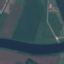

In [134]:
im

In [135]:
EuroSAT_labels = dict(enumerate(open('data/EuroSATLabels.txt')))

In [136]:
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {EuroSAT_labels[idx.item()]}', end='')

Prediction Label and Attention Map!

0.96633 : River
0.02871 : Annual Crop
0.00333 : Pasture
0.00072 : Highway
0.00056 : Permanent Crop


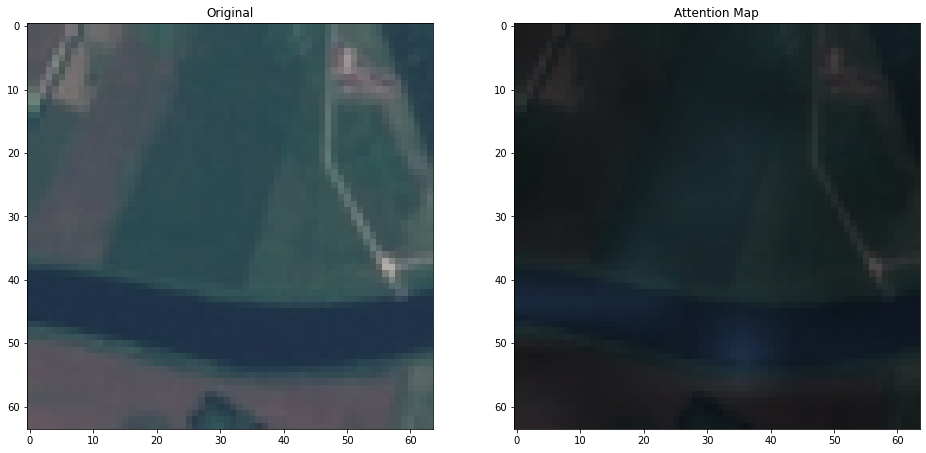

In [137]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

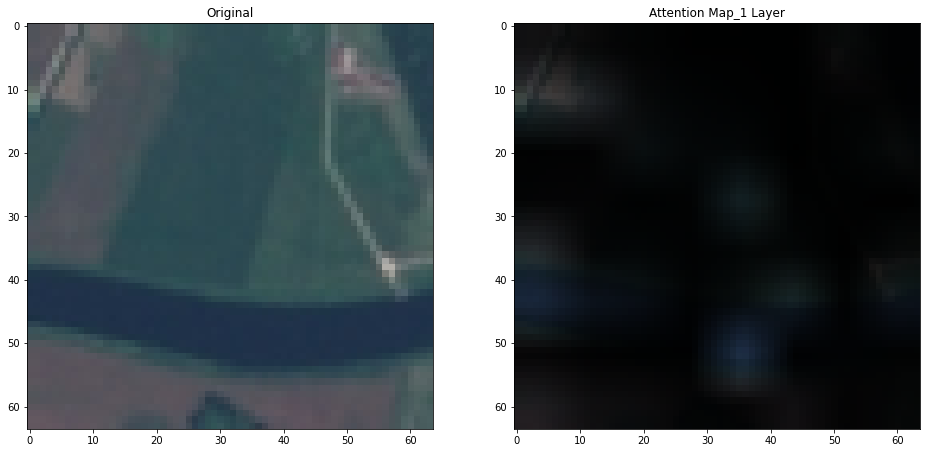

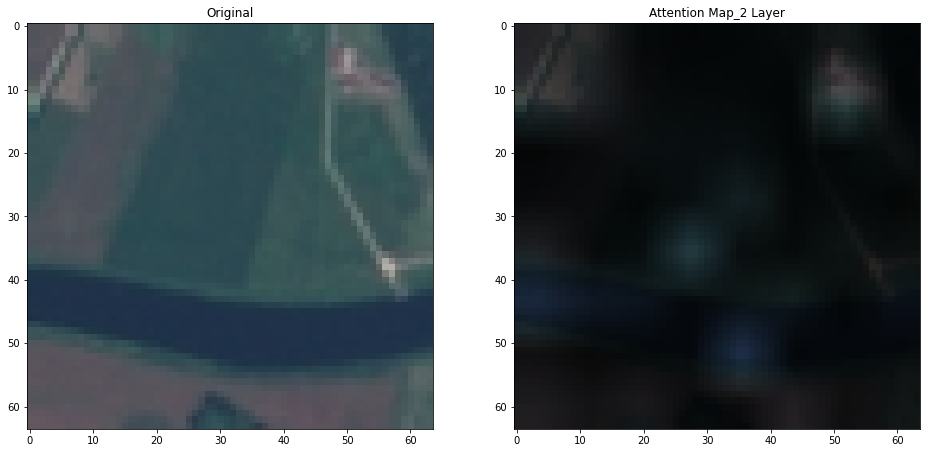

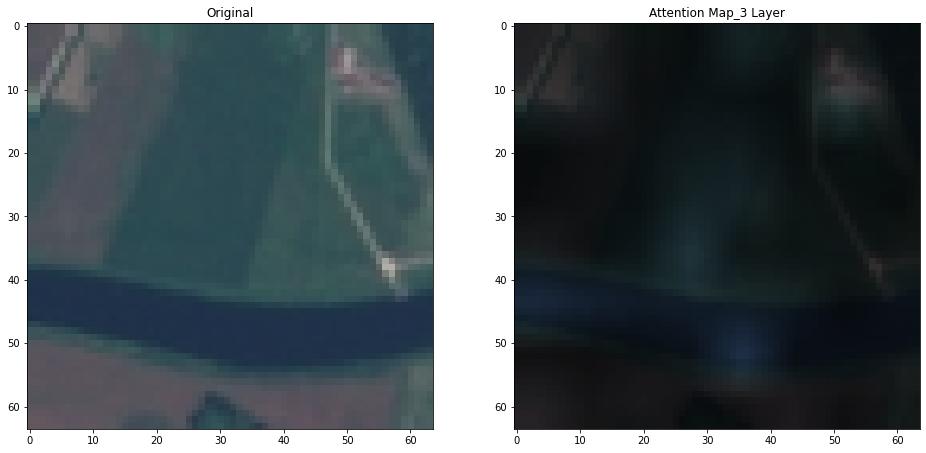

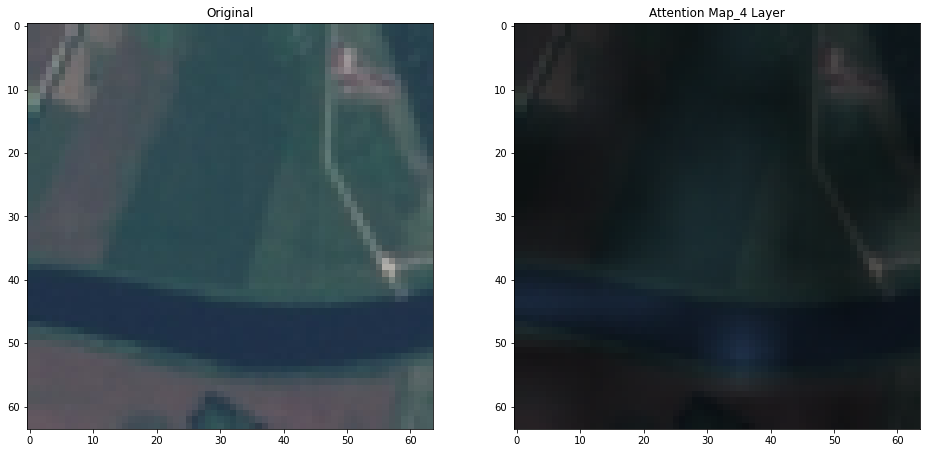

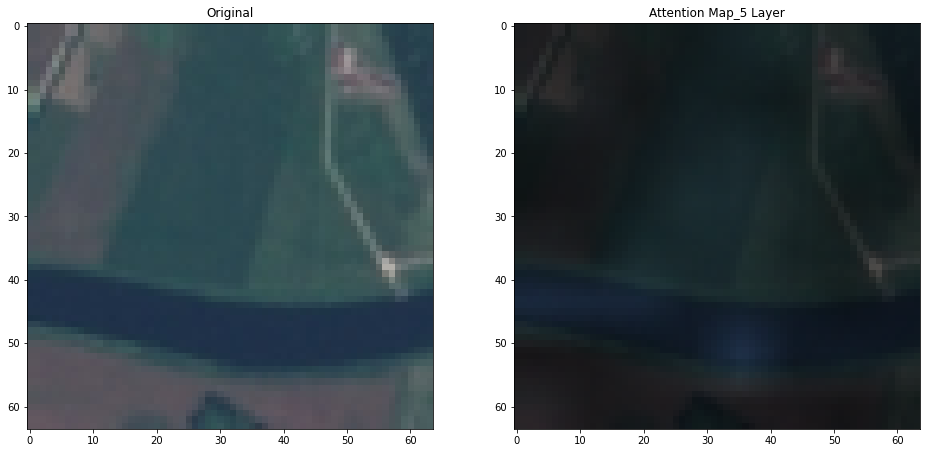

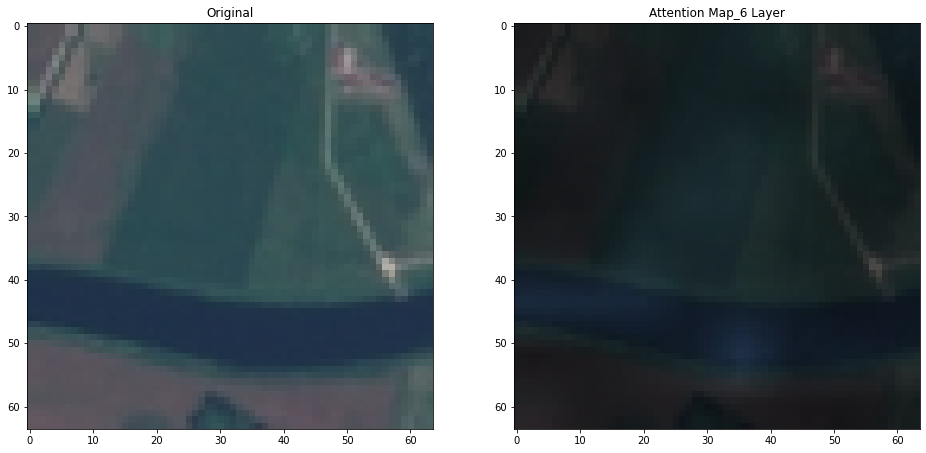

In [138]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(result)
